In [8]:
pip install tensorflow numpy matplotlib kaggle pandas

In [9]:
!mkdir ~/.kaggle

from google.colab import files
files.upload()

mkdir: cannot create directory ‘/root/.kaggle’: File exists


Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"joaopedrovm","key":"fc00e83c23586f30b54c103447ad7c9e"}'}

In [10]:
!cp kaggle.json ~/.kaggle
!chmod 600  ~/.kaggle/kaggle.json

In [11]:
!kaggle competitions download -c titanic

train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [12]:
# Import needed packages
import numpy as np # Arrays
import pandas as pd # Importing and organizing data
import matplotlib.pyplot as plt # Plotting
from scipy.integrate import simps # Simpson integration
from tensorflow import keras

# Plot font size
plt.rcParams.update({"font.size":24})

In [13]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
test_label = pd.read_csv("gender_submission.csv")

print(train.columns)
print(test.columns)
print(test_label.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Survived'], dtype='object')


In [14]:
train = np.array(train[["Survived", "Pclass", "Sex", "Age", "SibSp", "Parch", "Fare"]])

test_data = np.array(test[["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare"]])
test_label = np.array(test_label.Survived)

print(train.shape)
print(test_label.shape)
print(test_data.shape)
print(test_data)

(891, 7)
(418,)
(418, 6)
[[3 'male' 34.5 0 0 7.8292]
 [3 'female' 47.0 1 0 7.0]
 [2 'male' 62.0 0 0 9.6875]
 ...
 [3 'male' 38.5 0 0 7.25]
 [3 'male' nan 0 0 8.05]
 [3 'male' nan 1 1 22.3583]]


In [15]:
for i in range(len(train)):
    if (train[i,2] == "male"):
        train[i,2] = 0
    else:
        train[i,2] = 1

for i in range(len(test_data)):
    if (test_data[i,1] == "male"):
        test_data[i,1] = 0
    else:
        test_data[i,1] = 1

train = train.astype(np.float64)
test_data = test_data.astype(np.float64)

print(train)
print(test_data)

[[ 0.      3.      0.     ...  1.      0.      7.25  ]
 [ 1.      1.      1.     ...  1.      0.     71.2833]
 [ 1.      3.      1.     ...  0.      0.      7.925 ]
 ...
 [ 0.      3.      1.     ...  1.      2.     23.45  ]
 [ 1.      1.      0.     ...  0.      0.     30.    ]
 [ 0.      3.      0.     ...  0.      0.      7.75  ]]
[[ 3.      0.     34.5     0.      0.      7.8292]
 [ 3.      1.     47.      1.      0.      7.    ]
 [ 2.      0.     62.      0.      0.      9.6875]
 ...
 [ 3.      0.     38.5     0.      0.      7.25  ]
 [ 3.      0.         nan  0.      0.      8.05  ]
 [ 3.      0.         nan  1.      1.     22.3583]]


In [29]:
ages = train[:,3][np.where(np.isfinite(train[:,3]))[0]]
for i in np.where(np.isnan(train[:,3]))[0]:
    train[i,3] = np.random.normal(np.mean(ages), np.std(ages))

ages = test_data[:,2][np.where(np.isfinite(test_data[:,2]))[0]]
for i in np.where(np.isnan(test_data[:,2]))[0]:
    test_data[i,2] = np.random.normal(np.mean(ages), np.std(ages))

print(train.shape)
print(test_data.shape)

(891, 7)
(418, 6)


In [17]:
val_data = train[int(0.8*len(train)):,1:]
val_label = train[int(0.8*len(train)):,0]

train_data = train[:int(0.8*len(train)),1:]
train_label = train[:int(0.8*len(train)),0]

print(train_data.shape)
print(train_label.shape)
print(val_data.shape)
print(val_label.shape)
print(test_data.shape)
print(test_label.shape)

(712, 6)
(712,)
(179, 6)
(179,)
(418, 6)
(418,)


In [33]:
from tensorflow.keras.models import Sequential # Model of sequential layers
from tensorflow.keras.layers import Dense, Dropout # Layers to be used

# Model definition
model = Sequential([
                    Dense(256, activation="relu", input_shape=(train_data.shape[1],)),
                    Dropout(0.2),
                    Dense(256, activation="relu"),
                    Dropout(0.1),
                    Dense(64, activation="relu"),
                    Dropout(0.1),
                    Dense(2, activation="softmax"),
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               1792      
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                

In [34]:
# Model compilation
model.compile(
    optimizer = "adam",
    loss = "binary_crossentropy",
    metrics = ["accuracy"],
)

In [35]:
from tensorflow.keras.utils import to_categorical

# Model fitting
history = model.fit(
    train_data,
    to_categorical(train_label),
    epochs = 20,
    batch_size = 32,
    validation_data = (val_data, to_categorical(val_label))
)

Epoch 1/20
23/23 [==============================] - 0s 8ms/step - loss: 1.0911 - accuracy: 0.6222 - val_loss: 0.6270 - val_accuracy: 0.7095
Epoch 2/20
23/23 [==============================] - 0s 4ms/step - loss: 0.7691 - accuracy: 0.6067 - val_loss: 0.5771 - val_accuracy: 0.7374
Epoch 3/20
23/23 [==============================] - 0s 3ms/step - loss: 0.6905 - accuracy: 0.6587 - val_loss: 0.5580 - val_accuracy: 0.7374
Epoch 4/20
23/23 [==============================] - 0s 3ms/step - loss: 0.6578 - accuracy: 0.6657 - val_loss: 0.5769 - val_accuracy: 0.7151
Epoch 5/20
23/23 [==============================] - 0s 3ms/step - loss: 0.6420 - accuracy: 0.6685 - val_loss: 0.5686 - val_accuracy: 0.7039
Epoch 6/20
23/23 [==============================] - 0s 4ms/step - loss: 0.6338 - accuracy: 0.6601 - val_loss: 0.5746 - val_accuracy: 0.7318
Epoch 7/20
23/23 [==============================] - 0s 3ms/step - loss: 0.6405 - accuracy: 0.6657 - val_loss: 0.5452 - val_accuracy: 0.7095
Epoch 8/20
23/23 [==

In [24]:
def confusion_matrix(pred, label):

    n = np.max(pred)+1
    cm = np.zeros((n,n))

    for i in range(n):

        real = np.where(label == i)[0]

        for j in range(n):
            
            cm[i,j] = len(np.where(pred[real] == j)[0])

    return cm

Correct predictions for Train data: 73.60%
Correct predictions for Validation data: 77.65%
Correct predictions for Test data: 77.27%


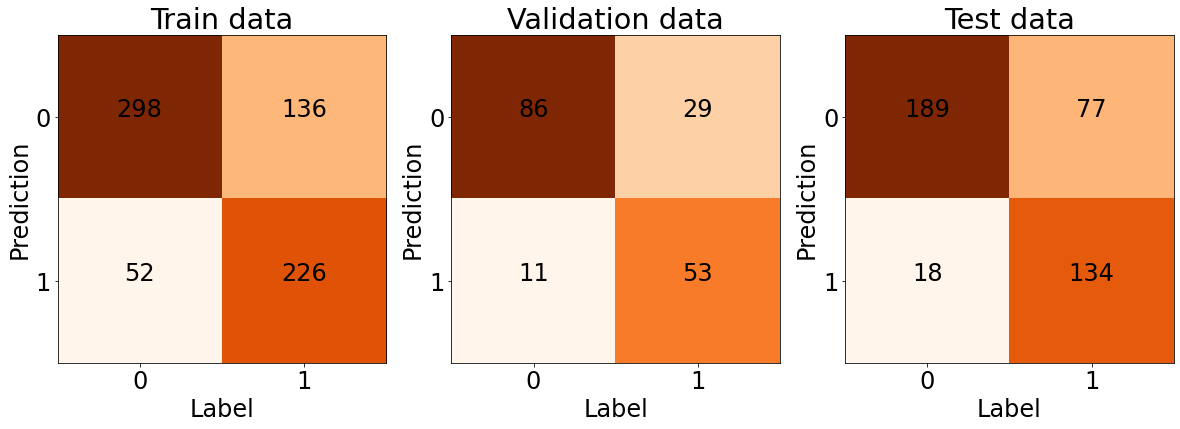

In [27]:
data_label = [[train_data, train_label, "Train"], [val_data, val_label, "Validation"], [test_data, test_label, "Test"]]

plt.figure(figsize=(20,7))
for k in range(3):
    plt.subplot(1,3,k+1)
    pred = np.argmax(model.predict(data_label[k][0]), axis=1)

    cm = confusion_matrix(pred, data_label[k][1])
    print(r"Correct predictions for %s data: %.2f%%" % (data_label[k][2], np.trace(cm)/np.sum(cm)*100))

    plt.imshow(cm, cmap="Oranges")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, "%i"%cm[i,j], ha="center")
    plt.xticks(np.unique(pred))
    plt.yticks(np.unique(data_label[k][1]))
    plt.xlabel("Label")
    plt.ylabel("Prediction")
    plt.gca().set_title("%s data" % (data_label[k][2]))